In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchinfo
from torch.utils.data import DataLoader
import time
import copy

# BasicConv2d: 합성곱 + BatchNorm + ReLU (공식 구현 참고)

In [24]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)

        return F.relu(x, inplace=True)

# Inception 모듈 (BasicConv2d 사용)

In [25]:
class Inception(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True), # ceil_mode = True :  올림을 이용하여 계산
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)
        return torch.cat([branch1, branch2, branch3, branch4], dim=1)

# Auxiliary Classifier (옵션)

In [26]:
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.dropout = nn.Dropout(0.7)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
        

# GoogLeNet (Inception v1) 모델 (공식 구현 참고)

In [27]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=10, aux_logits=False, transform_input=False):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = BasicConv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(in_channels=64, out_channels=64, kernel_size=1)
        self.conv3 = BasicConv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception3a = Inception(
            in_channels=192, 
            ch1x1=64, 
            ch3x3red=96, 
            ch3x3=128, 
            ch5x5red=16, 
            ch5x5=32, 
            pool_proj=32
        ) # ---> 256ch output
        self.inception3b = Inception(
            in_channels=256, 
            ch1x1=128, 
            ch3x3red=128, 
            ch3x3=192, 
            ch5x5red=32, 
            ch5x5=96, 
            pool_proj=64
        ) # ---> 480ch output
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception4a = Inception(
            in_channels=480, 
            ch1x1=192, 
            ch3x3red=96, 
            ch3x3=208, 
            ch5x5red=16, 
            ch5x5=48, 
            pool_proj=64
        ) # ---> 512ch output

        self.inception4b = Inception(
            in_channels=512, 
            ch1x1=160, 
            ch3x3red=112, 
            ch3x3=224, 
            ch5x5red=24, 
            ch5x5=64, 
            pool_proj=64
        ) # ---> 512ch output

        self.inception4c = Inception(
            in_channels=512, 
            ch1x1=128, 
            ch3x3red=128, 
            ch3x3=256, 
            ch5x5red=24, 
            ch5x5=64, 
            pool_proj=64
        ) # ---> 512ch output

        self.inception4d = Inception(
            in_channels=512, 
            ch1x1=112, 
            ch3x3red=144, 
            ch3x3=288, 
            ch5x5red=32, 
            ch5x5=64, 
            pool_proj=64
        ) # ---> 528ch output

        self.inception4e = Inception(
            in_channels=528, 
            ch1x1=256, 
            ch3x3red=160, 
            ch3x3=320, 
            ch5x5red=32, 
            ch5x5=128, 
            pool_proj=128
        ) # ---> 832ch output

        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        self.inception5a = Inception(
            in_channels=832, 
            ch1x1=256, 
            ch3x3red=160, 
            ch3x3=320, 
            ch5x5red=32, 
            ch5x5=128, 
            pool_proj=128
        ) # ---> 832ch output

        self.inception5b = Inception(
            in_channels=832, 
            ch1x1=384, 
            ch3x3red=192, 
            ch3x3=384, 
            ch5x5red=48, 
            ch5x5=128, 
            pool_proj=128
        ) # ---> 1024ch output

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1)) # ---> 1024 x 1 x 1 
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if self.aux_logits:
            self.aux1 = AuxiliaryClassifier(in_channels=512, num_classes=num_classes)
            self.aux2 = AuxiliaryClassifier(in_channels=528, num_classes=num_classes)

    def forward(self, x):
        if self.transform_input:
            # 필요하면 여기에 변화코드 추가
            pass
        
        # 224 x 224 입력을 예상
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        x = self.inception4a(x)
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)
        else:
            aux1 = None

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)
        else:
            aux2 = None
        x = self.inception4e(x)
        x = self.maxpool4(x)

        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        main_out = self.fc(x)

        if self.aux_logits and self.training:
            return main_out, aux2, aux1
        else:
            return main_out

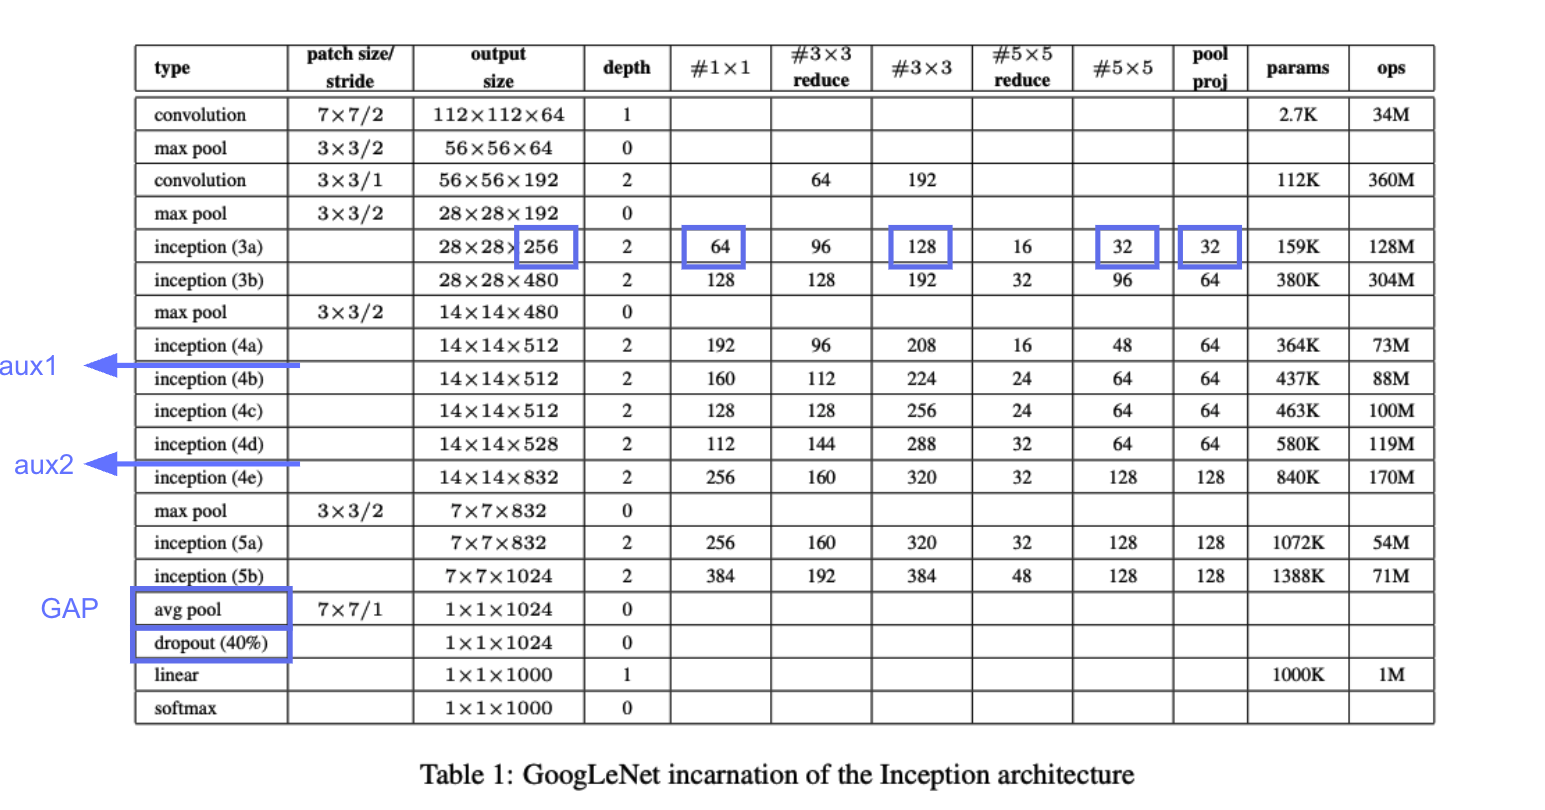

In [29]:
from torchinfo import summary

model = GoogLeNet(num_classes=1000, aux_logits=True)
summary(model, input_size=(2,3,224,224), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
GoogLeNet                                [2, 1000]                 6,379,984
├─BasicConv2d: 1-1                       [2, 64, 112, 112]         --
│    └─Conv2d: 2-1                       [2, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [2, 64, 112, 112]         128
├─MaxPool2d: 1-2                         [2, 64, 56, 56]           --
├─BasicConv2d: 1-3                       [2, 64, 56, 56]           --
│    └─Conv2d: 2-3                       [2, 64, 56, 56]           4,096
│    └─BatchNorm2d: 2-4                  [2, 64, 56, 56]           128
├─BasicConv2d: 1-4                       [2, 192, 56, 56]          --
│    └─Conv2d: 2-5                       [2, 192, 56, 56]          110,592
│    └─BatchNorm2d: 2-6                  [2, 192, 56, 56]          384
├─MaxPool2d: 1-5                         [2, 192, 28, 28]          --
├─Inception: 1-6                         [2, 256, 28, 28]       

In [30]:
# 클래스 정보 파일 불러오기
# https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

import requests

# URL 설정
url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"

# 요청하여 파일 불러오기
response = requests.get(url)

# 텍스트 데이터를 리스트로 변환 (각 줄을 요소로 저장)
imagenet_classes = response.text.strip().split("\n")

# 결과 확인 (앞부분 10개 출력)
print(imagenet_classes)  # ['tench, Tinca tinca', 'goldfish, Carassius auratus', ...]


['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel', 'kite', 'bald eagle', 'vulture', 'great grey owl', 'European fire salamander', 'common newt', 'eft', 'spotted salamander', 'axolotl', 'bullfrog', 'tree frog', 'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle', 'terrapin', 'box turtle', 'banded gecko', 'common iguana', 'American chameleon', 'whiptail', 'agama', 'frilled lizard', 'alligator lizard', 'Gila monster', 'green lizard', 'African chameleon', 'Komodo dragon', 'African crocodile', 'American alligator', 'triceratops', 'thunder snake', 'ringneck snake', 'hognose snake', 'green snake', 'king snake', 'garter snake', 'water snake', 'vine snake', 'night snake', 'boa constrictor', 'rock python', 'Indian cobra', 'green mamba', 'sea snake', 'horned viper', 'diamondback', 

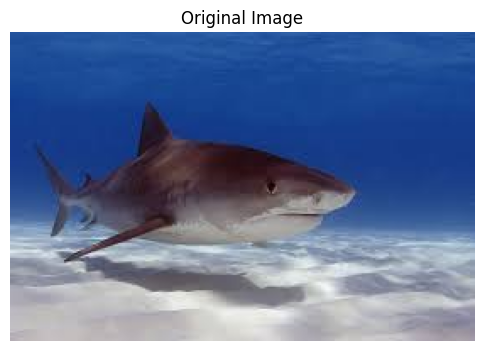

Top 5 예측 결과:
tiger shark: 0.9425
great white shark: 0.0279
axolotl: 0.0011
airship: 0.0008
geyser: 0.0006


In [31]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt


# 1. 이미지 다운로드 및 로드
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQPqUIvVs_Q2veVfJXJgmU4HqJDedpaLTb5Vg&s'
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')  # 확실한 RGB 변환

# 이미지 시각화 (원본 이미지)
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis('off')
plt.title("Original Image")
plt.show()

# 2. 전처리: AlexNet은 ImageNet 기준으로 학습되었으므로, 해당 전처리 과정을 사용합니다.
preprocess = transforms.Compose([
    transforms.Resize(256),               # 짧은 변을 256픽셀로 조정
    transforms.CenterCrop(224),           # 정중앙에서 224x224 크롭
    transforms.ToTensor(),                # 텐서 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet 평균
                         std=[0.229, 0.224, 0.225])   # ImageNet 표준편차
])

img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)  # 배치 차원 추가

# 3. 모델 로드 및 평가 모드 설정
#model = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
model = models.googlenet(weights='GoogLeNet_Weights.IMAGENET1K_V1')
model.eval()  # 평가 모드로 전환

# 4. 추론 진행 (with torch.no_grad()로 gradient 계산 방지)
with torch.no_grad():
    output = model(batch_t)

# 5. softmax를 통해 클래스 확률 계산 및 Top5 예측
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top5_prob, top5_catid = torch.topk(probabilities, 5)

print("Top 5 예측 결과:")
for i in range(top5_prob.size(0)):
    print(f"{imagenet_classes[top5_catid[i]]}: {top5_prob[i].item():.4f}")
